In [5]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

import astropy.coordinates as coord
from astropy.io import ascii
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.coordinates import match_coordinates_sky

from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch

Vizier.ROW_LIMIT = 9999999

# PLOT STYLE
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-colorblind') # Color blind friendly palette

In [7]:
# Load the HWO catalog data from CSV (consider using absolute path or config for portability)
df_HWO = pd.read_csv('HPICv1.0/full_HPIC.txt', sep='|')
df_HWO = df_HWO.reset_index(drop=True)

df_catalogs_info = pd.read_csv('act.catalogs.info.csv',comment='#').reset_index(drop=True)
with open('act.catalogs.cols.json', 'r') as f:
    cols = json.load(f)
# Convert dictionary to a pandas DataFrame
# The key will be the column name, and the list will become the rows under that column
df_cols = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cols.items()]))
#display(df_cols)

rad_search = 2.0

for catalog,vizier_code in zip(df_catalogs_info['catalog'],df_catalogs_info['vizier_code']):

    print(f"CROSSMATCH: Catalog and Vizier code - {catalog} {vizier_code} ::::::::::::::::::::::::::")
    # Load the Vizier catalog (Astropy Table)
    astab_viziercat = Vizier.get_catalogs(vizier_code)
    # Extract the desired catalog
    astab_catalog = astab_viziercat[0] 
    # Print column names of the Vizier catalog (for reference)
    #print("CROSSMATCH: Columns in Vizier Catalog:", astab_catalog.colnames)
    try:
        astab_catalog = astab_catalog[~astab_catalog['RAJ2000'].mask]
        #astab_catalog['RAJ2000'] = astab_catalog['RAJ2000']  * u.hourangle
        #print(astab_catalog['RAJ2000'])
        astab_catalog = astab_catalog[~astab_catalog['DEJ2000'].mask]
        #astab_catalog['DEJ2000'] = astab_catalog['DEJ2000']  * u.deg

        # HWO List SkyCoord object
        c1 = SkyCoord(df_HWO['ra']*u.deg, df_HWO['dec']*u.deg, frame='icrs')
        # Vizier catalog SkyCoord object
        c2 = SkyCoord(astab_catalog['RAJ2000'], astab_catalog['DEJ2000'], frame='icrs',unit=(u.hourangle, u.deg))

    except:
        astab_catalog = astab_catalog[~astab_catalog['_RA'].mask]
        astab_catalog = astab_catalog[~astab_catalog['_DE'].mask]
        # HWO List SkyCoord object
        c1 = SkyCoord(df_HWO['ra']*u.deg, df_HWO['dec']*u.deg, frame='icrs')
        # Vizier catalog SkyCoord object
        c2 = SkyCoord(astab_catalog['_RA'], astab_catalog['_DE'], frame='icrs')

       
    # Defining condition of radius of search
    max_sep = rad_search * u.arcsec
    # Crossmatch between HWO List (c1) and Vizier catalog (c2)
    idx, d2d, d3d = c1.match_to_catalog_sky(c2)

    #Separation constrain condition
    sep_constraint = d2d < max_sep
    # Coordinate matches from the HWO list and Vizier catalog
    c_matches = c1[sep_constraint]
    #print('c_matches',c_matches)

    # Matches from HWO list in the given Vizier catalog
    astab_catalog_matches = astab_catalog[idx[sep_constraint]]
    #display("Matched entries from Vizier catalog:\n",astab_catalog_matches)

    # HWO list's data of matched stars from the Vizier Catalog
    astab_my_matches = df_HWO[sep_constraint]
    #display("Matched stars from HWO catalog:\n",astab_my_matches)
    
    columns_serie = df_cols[catalog]
    columns = columns_serie.dropna().tolist()
    #print(type(columns))
    #print(columns)

    print("CROSSMATCH: Creating CSV file")
    table1 = df_HWO 
    table2 = astab_catalog_matches[columns].to_pandas()
    merged_df = pd.merge(table1, table2, left_index=True, right_index=True)
    merged_df.to_csv('20241113.HWO.'+catalog+'.merge.csv',index=False)
    print("CROSSMATCH: Done")
    #sys.exit()

CROSSMATCH: Catalog and Vizier code - Henry96 J/AJ/111/439 ::::::::::::::::::::::::::
CROSSMATCH: Creating CSV file
CROSSMATCH: Done
CROSSMATCH: Catalog and Vizier code - White07 J/AJ/133/2524/table1 ::::::::::::::::::::::::::
CROSSMATCH: Creating CSV file
CROSSMATCH: Done
CROSSMATCH: Catalog and Vizier code - Boro18 J/A+A/616/A108/catalog ::::::::::::::::::::::::::
CROSSMATCH: Creating CSV file
CROSSMATCH: Done
CROSSMATCH: Catalog and Vizier code - Adibekyan12 J/A+A/545/A32/table45 ::::::::::::::::::::::::::


CROSSMATCH: Creating CSV file
CROSSMATCH: Done
CROSSMATCH: Catalog and Vizier code - Rice2020 J/ApJ/898/119/table5 ::::::::::::::::::::::::::
CROSSMATCH: Creating CSV file
CROSSMATCH: Done
CROSSMATCH: Catalog and Vizier code - Brewer2016 J/ApJS/225/32 ::::::::::::::::::::::::::


CROSSMATCH: Creating CSV file
CROSSMATCH: Done
CROSSMATCH: Catalog and Vizier code - Holmberg2007 V/117A/newcat ::::::::::::::::::::::::::


CROSSMATCH: Creating CSV file
CROSSMATCH: Done
CROSSMATCH: Catalog and Vizier code - Cincunegui2007 J/A+A/469/309/table2 ::::::::::::::::::::::::::


CROSSMATCH: Creating CSV file
CROSSMATCH: Done


# NOTES

In [ ]:
astab_viziercat = Vizier.get_catalogs('V/117A/newcat')
print(astab_viziercat[0].keys())

['Name', 'Comp', 'RAJ2000', 'DEJ2000', 'logTe', '__Fe_H_', 'Dist', 'VMAG', 'Age', 'Vmag', 'b-y', 'RVel', 'e_RVel', 'q', 'vsini', 'Simbad']


In [ ]:
table1 = df_HWO #.to_pandas().iloc[idx[sep_constraint]]
table2 = astab_catalog_matches[columns].to_pandas()
merged_df = pd.merge(table1, table2, left_index=True, right_index=True)
merged_df.to_csv('20241113.HWO.Vizier.merge.test2.csv')

In [ ]:
astab_viziercat = Vizier.get_catalogs('J/A+A/418/989')
print(astab_viziercat)
#astab_viziercat = Vizier.get_catalogs('J/A+A/545/A32/table45')
astab_catalog = astab_viziercat[0] # Extract the desired catalog
astab_catalog.columns

TableList with 1 tables:
	'0:V/117A/newcat' with 16 column(s) and 16682 row(s) 


<TableColumns names=('Name','Comp','RAJ2000','DEJ2000','logTe','__Fe_H_','Dist','VMAG','Age','Vmag','b-y','RVel','e_RVel','q','vsini','Simbad')>

# HR Diagrams
because they are fun to make (!)

In [ ]:
df_HWO = pd.read_csv('/Users/sebas_astrogsu/GSU Dropbox Dropbox/Jose Carrazco Gaxiola/Mac (2)/Documents/RECONS/HWO/HPICv1.0/full_HPIC.txt', sep='|')
df_HWO.keys()

Index(['star_name', 'ra', 'dec', 'ra_J2016', 'dec_J2016', 'tic_id',
       'gaia_dr2_id', 'gaia_dr3_id', 'hip_name', 'tm_name',
       ...
       'known_binary_fl', 'gaia_binary_fl', 'wds_comp', 'wds_sep',
       'wds_deltamag', 'GCNS_companion', 'GCNS_sep', 'GCNS_mag_diff',
       'sy_planets_flag', 'hostname'],
      dtype='object', length=124)

sy_gaiamag|sy_gaiamagerr|sy_gaiamagsrc|sy_gaiamag_reflink|sy_bpmag|sy_bpmagerr|sy_rpmag|sy_rpmagerr|sy_plx|sy_plxerr|sy_plxsrc|sy_plx_reflink|sy_dist|

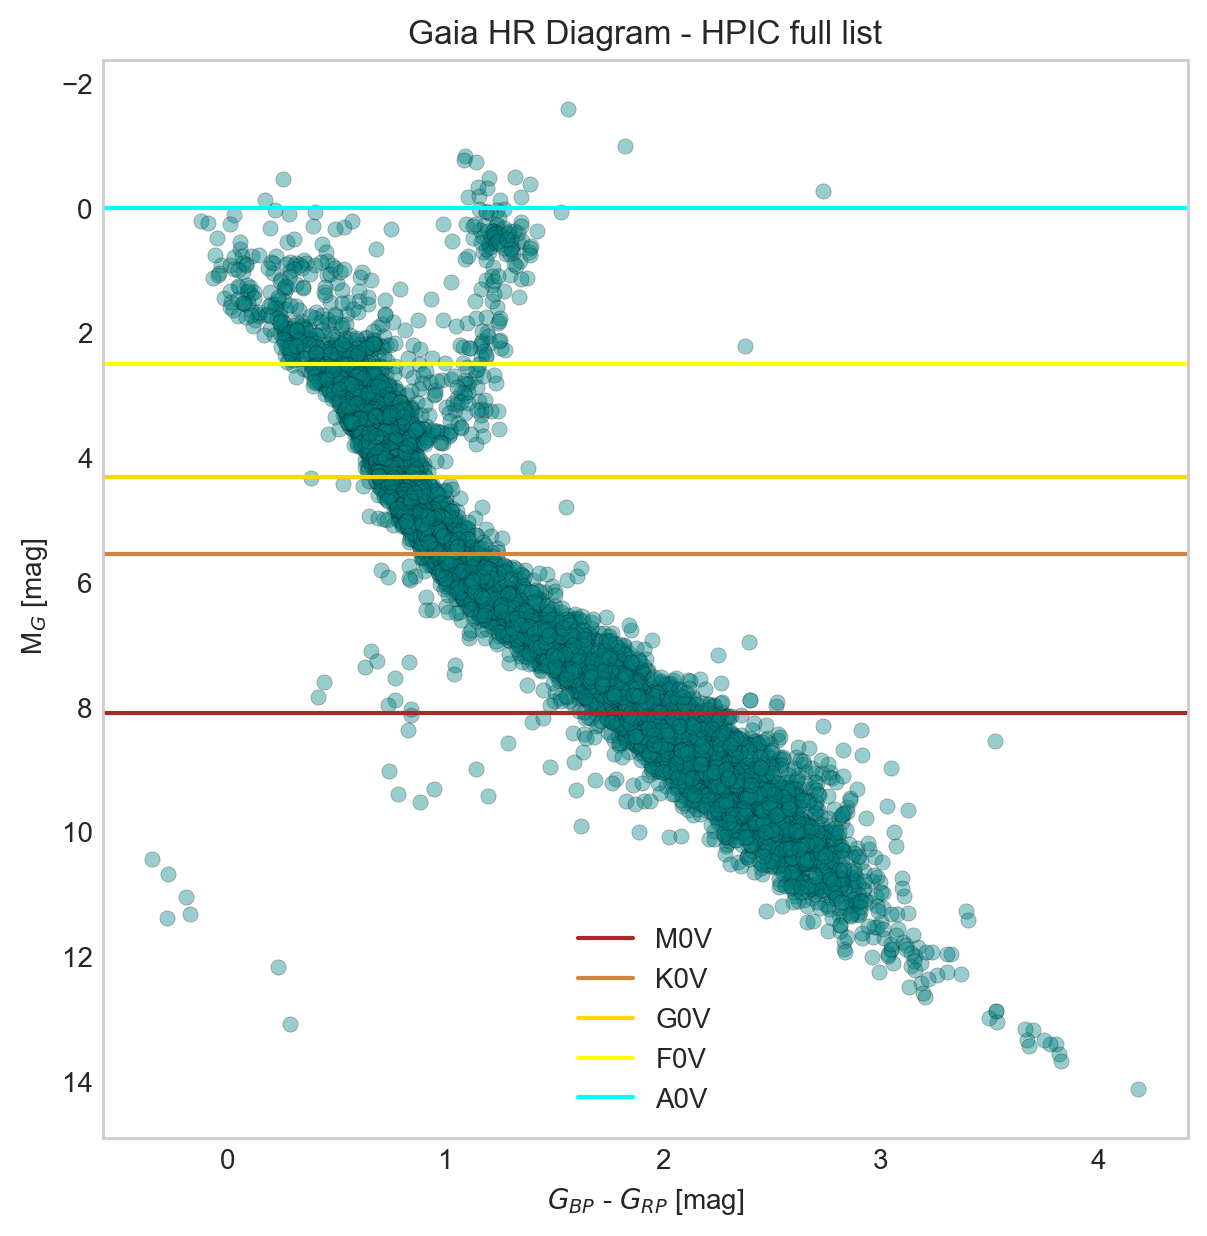

In [ ]:
G_mean = df_HWO['sy_gaiamag']  # Convert to float
Plx = df_HWO['sy_plx'] # Convert to float
MG = G_mean - 5*np.log10(1000/Plx) + 5
color = df_HWO['sy_bpmag'] - df_HWO['sy_rpmag']


fig, ax = plt.subplots(figsize=(7,7), dpi=200)
plt.scatter(color,MG, s=30, color='TEAL', alpha=0.4,edgecolors='BLACK',linewidth=0.2)

plt.axhline(8.1,color='brown',label='M0V')
plt.axhline(5.553,color='peru',label='K0V')
plt.axhline(4.32,color='gold',label='G0V')
plt.axhline(2.51,color='yellow',label='F0V')
plt.axhline(0,color='cyan',label='A0V')


plt.title('Gaia HR Diagram - HPIC full list')
plt.ylabel(r' M$_G$ [mag]')
plt.xlabel(r'$G_{BP}$ - $G_{RP}$ [mag]')
plt.grid(False)
plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.savefig('Gaia.HRD.HPIC.FullList.png', rasterize=True)
plt.savefig('Gaia.HRD.HPIC.FullList.pdf', rasterize=True)

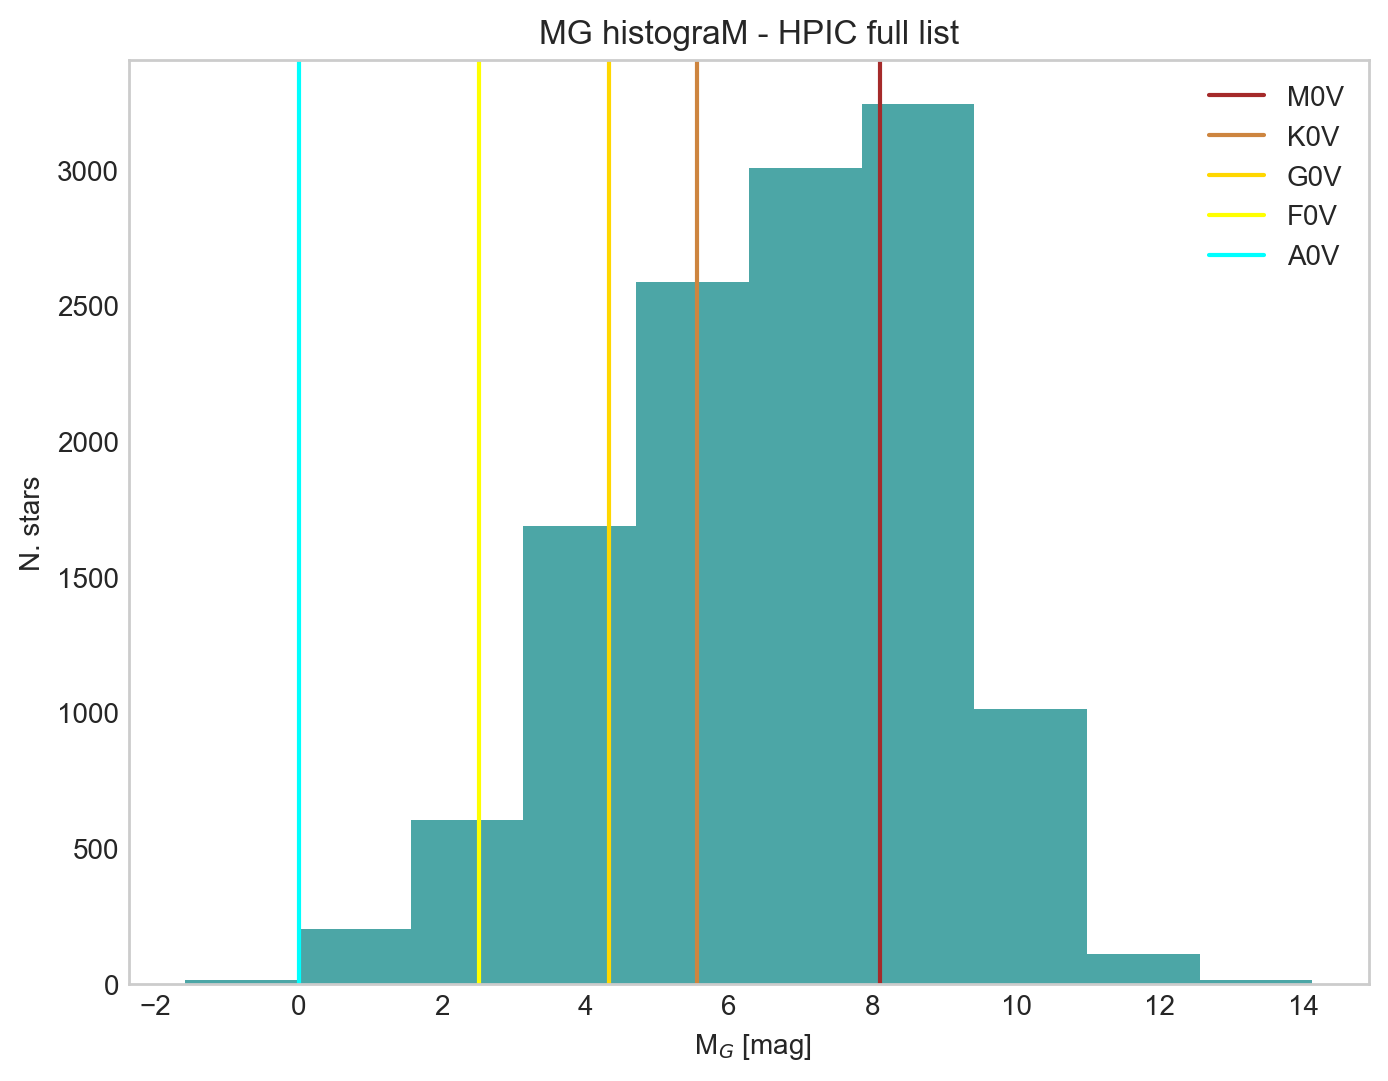

In [ ]:
Ffig, ax = plt.subplots(figsize=(8,6), dpi=200)
plt.hist(MG, color='TEAL', alpha=0.7,linewidth=0.2)

plt.axvline(8.1,color='brown',label='M0V')
plt.axvline(5.553,color='peru',label='K0V')
plt.axvline(4.32,color='gold',label='G0V')
plt.axvline(2.51,color='yellow',label='F0V')
plt.axvline(0,color='cyan',label='A0V')


plt.title('MG histograM - HPIC full list')
plt.ylabel(r'N. stars')
plt.xlabel(r' M$_G$ [mag]')
plt.grid(False)
plt.legend(loc='best')
plt.savefig('HPIC.FullList.Hist.png', rasterize=True)
plt.savefig('HPIC.FullList.Hist.pdf', rasterize=True)